In [ ]:
# TCC da Pós-graduação Lato Sensu em Ciência de Dados e Big Data
## Entidade promotora: PUC Minas Virtual
### Trabalho de Conclusão de Curso apresentado ao Curso de Especialização em Ciência de Dados e Big Data como requisito parcial à obtenção do título de especialista.
### Projeto: Preditores de óbitos por COVID-19: O aprendizado de máquina como instrumento auxiliar na definição de políticas públicas

### Aluno: Breno Marques Barreto

# Considerações importantes sobre a utilização dos modelos salvos:
# Deve-se conferir se a versão do Python que irá utilizar é a mesma usada neste projeto.
# Aconselha-se utilizar para deserializar o modelo salvo:
#   1 - A mesma versão do Python. 
#   2 - As mesmas versãoes das bibliotecas usadas no projeto. 
# As orientações não são apenas para as versões da NumPy e da scikit-learn.

# AJUSTE DO MODELO
## Os parâmetros serão ajuStados aos pares para evitar o alto custo computacional de ajustá-los todos ao mesmo tempo 

In [1]:
#Importa bibliotecas
import numpy as np
import pandas as pd
%run ./funcoes.ipynb

In [2]:
from sklearn.model_selection import train_test_split
#Carga dos dados já parcialmente tratados
#Produzida pelo notebook COVID_Preprocessamento.ipynb
arquivo_base = "INFLUD21-29-03-2021.csv"  
ext_file = "_processed_pre_dummies.csv"
rad_filename = arquivo_base[:-4]  #exclui a extensão do arquivo
filename_pre_des = rad_filename + ext_file
covid_df = load_df(filename_pre_des,";",None,None)  #carrega os dados

Arquivo informado: INFLUD21-29-03-2021_processed_pre_dummies.csv
Verifica existencia do arquivo: True
Arquivo INFLUD21-29-03-2021_processed_pre_dummies_143_proc_smote_over.csv foi encontrado.
Carregando o arquivo...
Concluído.


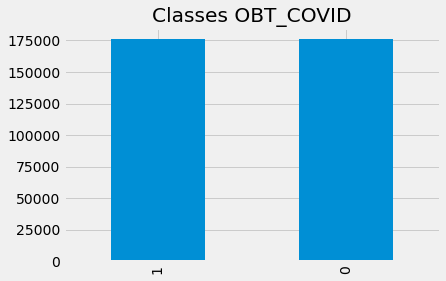

In [3]:
#Converte os tipos das variaveis do dataframe
covid_df_cat = converte_tipo_category(covid_df)
#Converte as variáveis categóricas em binárias (dummies)
covid_df_bin = converte_binarios(covid_df_cat) 
#Normalizada as colunas contínuas
covid_df_nor = normaliza_dados(covid_df_bin)
# Balanceamento da base de desenvolvimento Com SMOTE oversampling
covid_df_train_bal = imblearn_SMOTE_oversampling(covid_df_nor,filename_pre_des,False,'OBT_COVID')

In [4]:
labels = covid_df_train_bal.columns[:-1]  # presume-se que a última variável do dataframe é a alvo
X = covid_df_train_bal[labels]
y = covid_df_train_bal['OBT_COVID']

In [5]:
from sklearn.model_selection import train_test_split
# Divide a baase em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42,
  shuffle=True, stratify=y)

In [6]:
#Cria modelo com os parametros padrao
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1,
min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best')
y_pred = dt.predict(x_test)

In [7]:
#Teste de desempenho com os parametros padrao
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8239881764438381

In [8]:
def filtra_categoricals(covid_df):
    # Lista col_cat_srt armazenará as variáveis categóricas.
    col_cat = []  # armazenará os índices
    cat_col = covid_df.select_dtypes(include =['category']).columns # Todas as variáveis categóricas do dataframe.
    #print(cat_col)
    covid_df = covid_df[cat_col]  # seleciona apenas as categóricas
    return covid_df

In [9]:
#Função para converter os tipos das colunas com até 10 valores distintos em categoria
def converte_tipo_category(covid_df):
    col = covid_df.columns
    for i in col:
        if covid_df[i].nunique()<=10:     #Garante a conversão de "NU_IDADE_CAT"
            covid_df[i] = covid_df[i].astype('category')
    return covid_df

In [10]:
covid_df = converte_tipo_category(covid_df_train_bal)

In [11]:
 train = filtra_categoricals(covid_df)

## Ajuste de max_depth

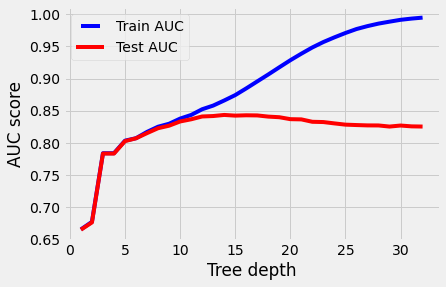

In [12]:
#Indica a profundade da árvore. Quanto maior,mais informação será retida. 
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Acrescenta auc score aos resultados de treino anteriores
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Acrescenta auc score aos resultados de testes anteriores
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [13]:
# Observa-se no gráfico que quanto maior a profundidade, notadamente valores maiores que 12/13, maior o overfitting à base de treino. O modelo prevê perfeitamente todos os labels da base de treino, entretanto, o mesmo não acontece na base de testes. 18 parece uma boa escolha.

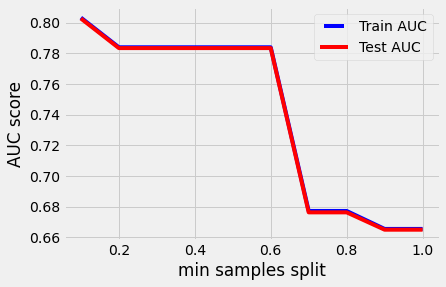

In [14]:
#Ajuste de min_samples_split
# Representa o número mínimo de amostras requerido para dividir um nó.
# Varia de 1 registro em cada nó até todos os registros em cada nó.
# Conforme o número aumenta, mais achatada fica a árvore. 
# No teste abaixo o valor ficará entre 10% e 100%

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()



In [15]:
#Observa-se no gráfico que as curvas na base de teste e de treino estão muito próximas. Assim, ao considerar um numero de amostras bem pequeno para split não resultará em underfitting.

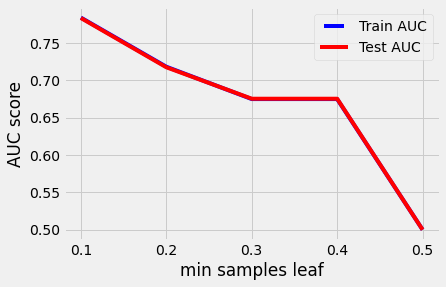

In [16]:
# Ajuste de min_samples_leaf
# Representa o número mínimo de registros requeridos em um nó "folha".
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

In [17]:
# A conclusão é similar à do parametro anterior. Seu aumento acaba causando underfitting. AUC reduz sem que igualmente na base de treino e de testes. Indica-se utilização de um número pequeno. 

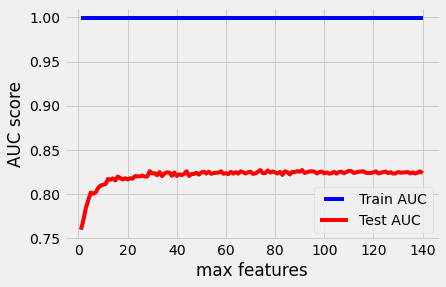

In [18]:
#Ajuste de max_features
#Ajusta o número de "features" a serem consideradas quando decidindo-se por um "split"
max_features = list(range(1,train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(max_features=max_feature)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()




In [19]:
# Observa-se que a partir de 30 features não ocorre incremento significativo no AUC na base de testes. A diferença no indicador nas bases de testes e treino aponta ouverfitting com qualquer número de escolhido. A documentação do sklearn para árvores de decisão informa que a busca por splits não para até que uma partição válida seja encontrada. Ainda que o parâmetro max_features tenha que ser desconsiderado.

In [22]:
# Reavaliação do modelo com os parâmetros ajustados
params_DecisionTree = {'ccp_alpha':0.0,
                'class_weight':None,
                'criterion':'gini',
                'max_depth':13,
                'max_features':None,
                'max_leaf_nodes':None,
                'min_impurity_decrease':0.0,
                'min_impurity_split':None,
                'min_samples_leaf':1,
                'min_samples_split':2,
                'min_weight_fraction_leaf':0.0,
                'presort':'deprecated',
                'random_state':3534,
                'splitter':'best'
}
dt2 = DecisionTreeClassifier(**params_DecisionTree)
dt2.fit(x_train, y_train)
y_pred2 = dt2.predict(x_test)

In [23]:
#Teste de desempenho com os parametros padrao
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8417462482946795